# Parareal Example

## Helper Functions

In [1]:
import xml.etree.ElementTree as ET
from xml.dom import minidom

class Precursor:
    def __init__(self, decay_constant, beta):
        self.decay_constant = decay_constant
        self.beta = beta
        
class Precomp:
    def __init__(self, time, power, rho, concentrations):
        self.time = time
        self.power = power
        self.rho  = rho
        self.concentrations = concentrations
        
class Params:
    def __init__(self, time=None, rho_imp=None, lambda_h=None, 
                 gen_time=None, pow_norm=None, beta_eff=None, 
                 theta=None, gamma_d=None, eta=None, max_iter=1,
                 n_fine_per_coarse = 1, interpolated=True):
        self.time = time
        self.rho_imp = rho_imp
        self.lambda_h = lambda_h
        self.gen_time = gen_time
        self.pow_norm = pow_norm
        self.beta_eff = beta_eff
        self.theta = theta
        self.gamma_d = gamma_d
        self.eta = eta
        self.max_iter = max_iter
        self.n_fine_per_coarse = n_fine_per_coarse
        self.interpolated = interpolated
        
def write_input_xml(precomp, params, precursors):
    parareal = ET.Element("parareal", 
                          outpath="examples/epke_output.xml", 
                          max_iterations=str(params.max_iter), 
                          n_fine_per_coarse=str(params.n_fine_per_coarse))
    
    # epke precomputed values (initial conditions)
    epke_output = ET.SubElement(parareal,"epke_output", n_steps=str(len(precomp.time)))
    ET.SubElement(epke_output, "time").text = ' '.join(map(str,precomp.time))
    ET.SubElement(epke_output, "power").text = ' '.join(map(str,precomp.power))
    ET.SubElement(epke_output, "rho").text = ' '.join(map(str,precomp.rho))
    concentrations_element = ET.SubElement(epke_output, "concentrations")
    
    # epke parameters
    epke_input = ET.SubElement(parareal,"epke_input", 
                               n_steps=str(len(params.time)), 
                               theta=str(params.theta), 
                               gamma_d=str(params.gamma_d),
                               eta=str(params.gamma_d), 
                               interpolated=str(params.interpolated).lower())
    
    ET.SubElement(epke_input, "time").text = ' '.join(map(str, params.time))
    ET.SubElement(epke_input, "rho_imp").text = ' '.join(map(str, params.rho_imp))
    
    if (params.gen_time is not None):
        ET.SubElement(epke_input, "gen_time").text = ' '.join(map(str, params.gen_time))
    else:
        ET.SubElement(epke_input, "gen_time", value="1.58e-5")
    
    if (params.pow_norm is not None):
        ET.SubElement(epke_input, "pow_norm").text = ' '.join(map(str, params.pow_norm))
    else:
        ET.SubElement(epke_input, "pow_norm", value="1.0")
    
    ET.SubElement(epke_input, "beta_eff").text = ' '.join(map(str,params.beta_eff))
    ET.SubElement(epke_input, "lambda_h").text = ' '.join(map(str,params.lambda_h))
    
    precursors_element = ET.SubElement(epke_input, "precursors")
    for k, precursor in enumerate(precursors):
        precursor_element = ET.SubElement(precursors_element, "precursor", k=str(k))
        ET.SubElement(precursor_element, "decay_constant", value=str(precursor.decay_constant))
        ET.SubElement(precursor_element, "delayed_fraction", value=str(precursor.beta))
        ET.SubElement(concentrations_element, "concentration", 
                      k=str(k)).text = ' '.join(map(str, precomp.concentrations[k])) 
    
    # pretty print and write to xml
    xmlstr = minidom.parseString(ET.tostring(parareal)).toprettyxml(indent=" ")
    
    with open("epke_input.xml", "w") as f:
        f.write(xmlstr)
        
def read_output_from_file(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    epke_output = root.find('epke_output')
    concentrations_node = epke_output.find('concentrations')
    
    time = np.fromstring(epke_output.find('time').text, dtype=float, sep=' ')
    power = np.fromstring(epke_output.find('power').text, dtype=float, sep=' ')
    rho = np.fromstring(epke_output.find('rho').text, dtype=float, sep=' ')
    
    concentrations = np.empty(shape=(len(concentrations_node), len(time)), dtype=float)
    
    for child in concentrations_node:
        k = int(child.attrib.get('k'))
        concentrations[k] = np.fromstring(child.text, dtype=float, sep=' ')

    return Precomp(time, power, rho, concentrations)

def read_params_from_file(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    epke_params = root.find('epke_input')
    
    time = np.fromstring(epke_params.find('time').text, dtype=float, sep=' ')
    rho_imp = np.fromstring(epke_params.find('rho_imp').text, dtype=float, sep=' ')
    lambda_h = np.fromstring(epke_params.find('lambda_h').text, dtype=float, sep=' ')
    gen_time = np.fromstring(epke_params.find('gen_time').text, dtype=float, sep=' ')
    pow_norm = np.fromstring(epke_params.find('pow_norm').text, dtype=float, sep=' ')
    beta_eff = np.fromstring(epke_params.find('beta_eff').text, dtype=float, sep=' ')
    
    theta = float(epke_params.attrib.get('theta'))
    gamma_d = float(epke_params.attrib.get('gamma_d'))
    eta = float(epke_params.attrib.get('eta'))
    
    return Params(time, rho_imp, lambda_h, gen_time,
                  pow_norm, beta_eff, theta, gamma_d, eta)

def analytic_soln(lambduh, t, t1, t_step, up, down, p0):
    t1_i = round(t1*t_step)
    p0_soln = p0
    p_soln = np.zeros(len(t))
    p_soln[:(t1_i+1)] = p0_soln*np.exp(-lambduh*t[:(t1_i+1)])*\
                        (1/(1 - up*t[:(t1_i+1)]))**(lambduh/up + 1)
    p_soln[(t1_i+1):] = p_soln[t1_i]*np.exp(-lambduh*(t[(t1_i+1):] - t1))*((1 - up*t1)/\
                        (1 - up*t1 + down*(t[(t1_i+1):] - t1)))**(-lambduh/down + 1)
    return p_soln

## Generate Coarse Solve Input Data

In [358]:
import numpy as np

precursors = [Precursor(0.49405, 0.0076)]
beta_sum = sum([p.beta for p in precursors])

t_end = 6
t_step = 1 # number of time steps per second
t = np.linspace(0,t_end,t_end*t_step+1)

up = .5 # $/s (upwards reactivity ramp)
down = .1 # $/s (downwards reactivity ramp)
t1 = 1
t1_i = round(t1*t_step) # index of t1
rho_imp = np.zeros(len(t))
rho_imp[:(t1_i+1)] = up*t[:(t1_i+1)]
rho_imp[(t1_i+1):] = up*t1 - down*(t[(t1_i+1):] - t1)

beta_eff = beta_sum * np.ones(len(t))
rho_imp = rho_imp * beta_sum
gen_time = 2.6e-15 * np.ones(len(t))
lambduh_h = np.ones(len(t))
pow_norm = np.ones(len(t))
theta = 0.5
eta = 1.0
gamma_d = 0.0
max_iter = 1
n_fine_per_coarse = 1
interpolated = True

params = Params(t, rho_imp, lambduh_h, gen_time, 
                pow_norm, beta_eff, theta, gamma_d, 
                eta, max_iter, n_fine_per_coarse,interpolated)

# generate the initial conditions
precomp_time = [0.0]
precomp_power = [1.0]
precomp_rho = [rho_imp[0]]
precomp_concentrations = []

for j, precursor in enumerate(precursors):
    initial_concentration = precursor.beta*precomp_power[0]/precursor.decay_constant
    precomp_concentrations.append([initial_concentration])

precomp = Precomp(precomp_time, precomp_power, 
                  precomp_rho, precomp_concentrations)
    
# write to xml
write_input_xml(precomp, params, precursors)

## Run the Coarse Solve

In [359]:
import subprocess

args = "./epke-run examples/epke_input.xml".split()
popen = subprocess.Popen(args, cwd="..", stdout=subprocess.PIPE)
popen.wait()
while True:
    line = popen.stdout.readline()
    if not line:
        break
    print(line.rstrip().decode('utf-8'))

Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml


## Read the Coarse Output

In [360]:
fname = 'epke_output.xml'

coarse_params = read_params_from_file(fname)
rho_imp_out = coarse_params.rho_imp
beta_eff_out = coarse_params.beta_eff

coarse_output = read_output_from_file(fname)
time_out = coarse_output.time
p_out = coarse_output.power
rho_out = coarse_output.rho
concentrations_out = coarse_output.concentrations

## Plot the Coarse Reactivity

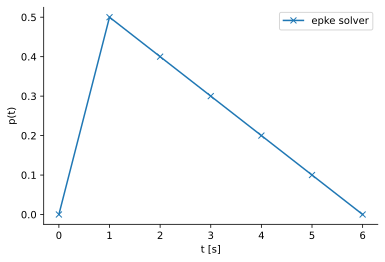

In [361]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

plt.plot(time_out, rho_imp_out/beta_eff_out, marker='x', label='epke solver')
plt.xlabel('t [s]')
plt.ylabel('p(t)')
plt.legend()
plt.savefig('parareal_reactivity.pdf')
plt.show()

## Plot the Coarse Power

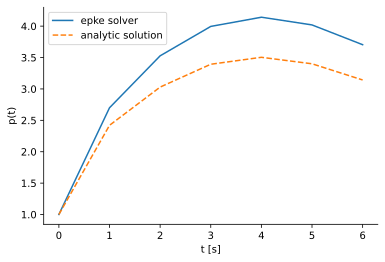

In [362]:
lambduh_list = np.asarray([p.decay_constant for p in precursors])
p_soln = analytic_soln(lambduh_list, time_out, t1, t_step, up, down, 1.0)

plt.plot(time_out, p_out, label='epke solver')
plt.plot(time_out, p_soln, linestyle='--', label='analytic solution')
plt.xlabel('t [s]')
plt.ylabel('p(t)')
plt.legend()
plt.show()

## Run the Parareal Algorithm

In [355]:
import subprocess

# write to xml
def run_parareal(max_iterations):
    coarse_params.interpolated = False
    coarse_params.max_iter = max_iterations
    coarse_params.n_fine_per_coarse = 200
    coarse_params.theta = 1.0
    write_input_xml(coarse_output, coarse_params, precursors)

    # run the parareal solver
    args = "./epke-run examples/epke_input.xml".split()
    popen = subprocess.Popen(args, cwd="..", stdout=subprocess.PIPE)
    popen.wait()
    while True:
        line = popen.stdout.readline()
        if not line:
            break
        print(line.rstrip().decode('utf-8'))

    return read_output_from_file(fname)

## Plot the Updated Power

Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml


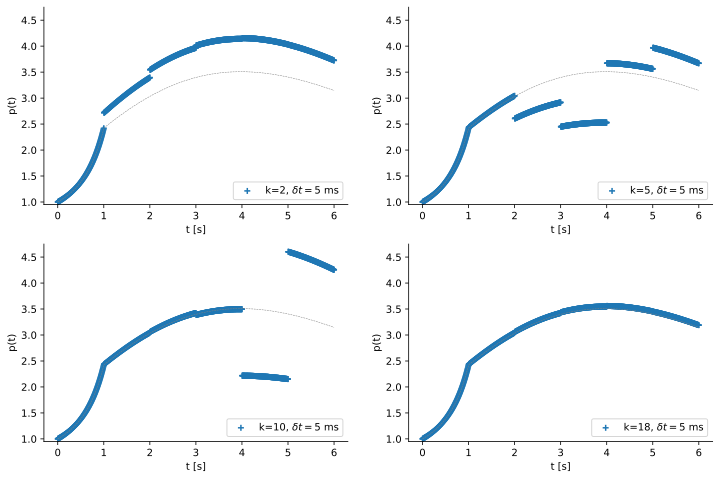

In [357]:
lambduh_list = np.asarray([p.decay_constant for p in precursors])
t_step = coarse_params.n_fine_per_coarse
t_analytic = np.linspace(0,6,6*t_step)
t1_i = round(t1*t_step) # index of t1
p_soln = analytic_soln(lambduh_list, t_analytic, t1, t_step, up, down, 1.0)

fig, axes = plt.subplots(2,2,figsize=(12,8))
#ax1.scatter(time_out, p_out, marker='x', label='k=0, $\Delta t = 1$ s')

max_iter_list = [2,5,10,18]
for i in range(len(max_iter_list)):
    updated_output = run_parareal(max_iter_list[i])
    
    updated_time_out = updated_output.time
    updated_p_out = updated_output.power
    updated_rho_out = updated_output.rho
    updated_concentrations_out = updated_output.concentrations

    ax = axes.flatten()[i]
    
    ax.plot(t_analytic, p_soln, linestyle='--', color=(0.5, 0.5, 0.5), linewidth=0.5)
    ax.scatter(updated_time_out, updated_p_out, marker='+', label='k='+str(coarse_params.max_iter)+', $\delta t = 5$ ms')
    ax.set_ylim(0.95, 4.75)
    ax.set_xlabel('t [s]')
    ax.set_ylabel('p(t)')
    ax.legend(loc=4)

plt.savefig('parareal_example.pdf')
plt.show()